In [1]:
using DifferentialEquations, LinearAlgebra
using Statistics, Folds
using Plots, LaTeXStrings
using JLD2
BLAS.set_num_threads(1)

In [2]:
function g(j, m)
    return (j + m) * (j - m + 1)
end

function rate_equations!(dρ, ρ, p, t)
    j = p[1]
    Γ = p[2]
    dS_z_dt = 0.0
    for m in -j:j
        idx = Int(m + j + 1)
        if m == j
            dρ[idx] = -Γ * g(j, m) * ρ[idx]
        elseif m == -j
            dρ[idx] = Γ * g(j, m + 1) * ρ[idx + 1]
        else
            dρ[idx] = -Γ * g(j, m) * ρ[idx] + Γ * g(j, m + 1) * ρ[idx + 1]
        end
        dS_z_dt += m * dρ[idx]
    end
    return dS_z_dt
end

rate_equations! (generic function with 1 method)

In [3]:
# ρ₀ = zeros(Float64, N + 1)
# ρ₀[end] = 1.0
# tspan = (0.0, 0.5)

# params = [j, Γ]

# prob = ODEProblem(rate_equations!, ρ₀, tspan, params)

# sol = solve(prob, Tsit5())

# function Sz_expectation(ρ, j)
#     return sum(m * ρ[Int(m + j + 1)] for m in -j:j) / j
# end

# Sz_vals_normalized = [Sz_expectation(sol(t), j) for t in sol.t]

# t_scaled = sol.t .* Γ

# plot(t_scaled, Sz_vals_normalized, xlabel="t * Γ", ylabel="⟨S_z⟩ / j", title="Expectation value of ⟨S_z⟩ / j over time", legend=false)


In [4]:
# function Sz_expectation(ρ, j)
#     return sum(m * ρ[Int(m + j + 1)] for m in -j:j) / j
# end

# Sz_vals_normalized = [Sz_expectation(sol(t), j) for t in sol.t]

# function radiated_intensity(Sz_vals_normalized, t_scaled)
#     dSz_dt = diff(Sz_vals_normalized) ./ diff(t_scaled)
#     return [-dSz_dt[1]; -dSz_dt]
# end

# γ_vals = radiated_intensity(Sz_vals_normalized, sol.t)

# t_scaled_γ = sol.t[1:end-1] .* N * Γ₀

# γ_vals_normalized = γ_vals ./ (N * Γ₀)

# plot(t_scaled_γ, γ_vals_normalized, xlabel="NΓ₀t", ylabel="γ(t)/NΓ₀", title="Radiated Intensity γ(t)/NΓ₀ vs NΓ₀t", legend=false)
# @save "radiated_intensity.jld2" t_scaled_γ γ_vals_normalized

In [5]:
# m_values = collect(-j:j)
# m_norm = m_values ./ j
# p = plot(xlim=(-1, 1), ylim=(0.0, 0.02), xlabel="m/j", ylabel="ρ(m, t)")

# Γ₀t_values = [0.0, 0.5 * log(N) / N, 1.0 * log(N) / N, 1.5 * log(N) / N, 2.0 * log(N) / N]

# for Γ₀t in Γ₀t_values
#     plot!(p, m_norm, sol(Γ₀t), label="Γ₀t = $Γ₀t")
# end

# display(p)
# @save "rate_equation_solution.jld2" p Γ₀t_values

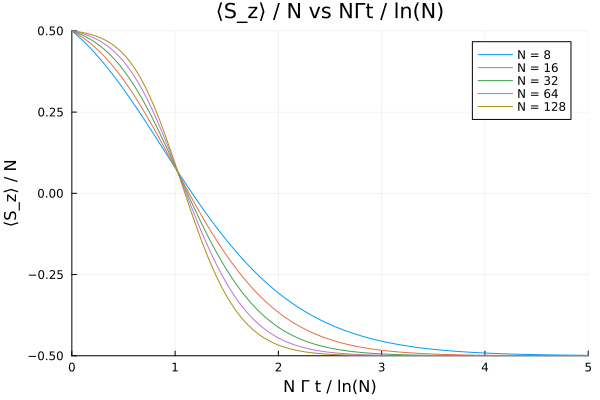

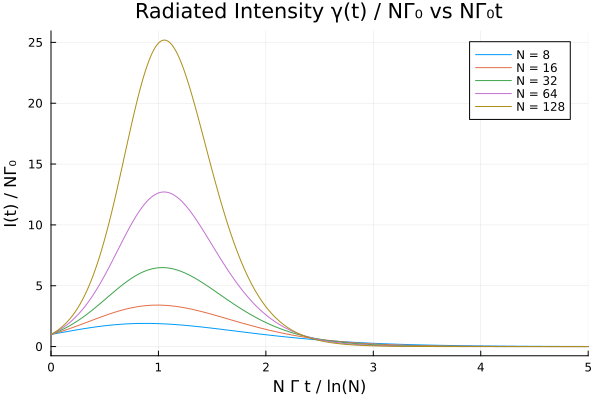

In [6]:
N_values = [8, 16, 32, 64, 128]
Γ = 1

p1 = plot(xlim=(0, 5), ylim=(-0.5, 0.5), xlabel="N Γ t / ln(N)", ylabel="⟨S_z⟩ / N", title="⟨S_z⟩ / N vs NΓt / ln(N)")

p2 = plot(xlim=(0, 5), xlabel="N Γ t / ln(N)", ylabel="I(t) / NΓ₀", title="Radiated Intensity γ(t) / NΓ₀ vs NΓ₀t")

function Sz_expectation(ρ, N)
    return sum(m * ρ[Int(m + N / 2 + 1)] for m in -N / 2:N / 2) / N
end

function compute_Sz_and_gamma(sol, t_vals, j)
    γ_vals = []
    for t in t_vals
        ρ_t = sol(t)
        dS_z_dt = rate_equations!(zeros(length(ρ_t)), ρ_t, [j, Γ], t)
        γ = -dS_z_dt
        push!(γ_vals, γ)
    end
    return γ_vals
end

for N in N_values
    j = N / 2

    ρ₀ = zeros(Float64, N + 1)
    ρ₀[end] = 1.0

    tspan = (0.0, 5 / (N * Γ / log(N)))

    params = [j, Γ]

    prob = ODEProblem(rate_equations!, ρ₀, tspan, params)
    sol = solve(prob, Tsit5())

    t_interp = range(tspan[1], tspan[2], length=400)

    Sz_vals_normalized = [Sz_expectation(sol(t), N) for t in t_interp]

    γ_vals_normalized = compute_Sz_and_gamma(sol, t_interp, j)

    t_scaled = t_interp * N * Γ / log(N)
    t_scaled_gamma = t_interp * N / log(N)

    plot!(p1, t_scaled, Sz_vals_normalized, label="N = $N")

    γ_normalized = γ_vals_normalized ./ (N * Γ)
    plot!(p2, t_scaled_gamma, γ_normalized, label="N = $N")

    # Save data to files
    # @save "Sz_vals_N_$N.jld2" Sz_vals_normalized
    # @save "gamma_vals_N_$N.jld2" γ_normalized
end

display(p1)
display(p2)


TWA

In [7]:
function sampleSpinZPlus()
    θ = acos(1 / sqrt(3))
    ϕ = 2π * rand()
    return θ, ϕ
end

sampleSpinZPlus (generic function with 1 method)

In [8]:
function prob_func(prob, i, repeat)
    u0 = Vector{Float64}(undef, 2 * nAtoms)
    for n in 1:nAtoms
        θn, ϕn = sampleSpinZPlus()
        u0[n] = θn
        u0[nAtoms + n] = ϕn
    end
    remake(prob, u0=u0)
end

prob_func (generic function with 1 method)

In [9]:
function drift!(du, u, p, t)
    Γ, nAtoms = p
    θ = u[1:nAtoms] 
    ϕ = u[nAtoms .+ (1:nAtoms)]

    for n = 1:nAtoms
        dθ_drift = 0.0
        dϕ_drift = 0.0
        for m = 1:nAtoms
            dθ_drift += sqrt(3) * sin(θ[m]) * (Γ / 2) * cos(ϕ[m] - ϕ[n])
            dϕ_drift += sin(θ[m]) * (Γ / 2) * sin(ϕ[m] - ϕ[n])
        end
        du[n] = (Γ / 2) * cot(θ[n]) + dθ_drift
        du[n + nAtoms] = sqrt(3) * cot(θ[n]) * dϕ_drift
    end
    nothing
end

function diffusion!(du, u, p, t)
    Γ, nAtoms = p
    θ = u[1:nAtoms]
    ϕ = u[nAtoms .+ (1:nAtoms)]
    for n = 1:nAtoms
        du[n, 1] = -sqrt(Γ) * cos(ϕ[n])
        du[n, 2] = sqrt(Γ) * sin(ϕ[n])
        du[nAtoms + n, 1] = sqrt(Γ) * cot(θ[n]) * sin(ϕ[n])
        du[nAtoms + n, 2] = sqrt(Γ) * cot(θ[n]) * cos(ϕ[n])
    end
    nothing
end

diffusion! (generic function with 1 method)

In [10]:
function computeTWA(nAtoms, tf, nT, nTraj, dt)
    tspan = (0, tf)
    tSave = LinRange(0, tf, nT)
    u0 = zeros(2 * nAtoms)
    p = (Γ, nAtoms)
    prob = SDEProblem(drift!, diffusion!, u0, tspan, p, noise_rate_prototype=zeros(2 * nAtoms, 2))
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    alg = EM()
    sol = solve(ensemble_prob, alg, EnsembleThreads();
        saveat=tSave, trajectories=nTraj, maxiters=1e+7, dt=dt,
        abstol=1e-5, reltol=1e-5)
    return tSave, sol
end

computeTWA (generic function with 1 method)

In [ ]:
Ω = 1
Δ = 0
Γ = 1
tf = 5
nT = 10
nTraj = 10
dt = 1e-3
nAtoms = 125
p = (Γ, nAtoms)
@time t,sol = computeTWA(nAtoms, tf, nT, nTraj, dt)

  9.055509 seconds (203.63 k allocations: 208.108 MiB)


(LinRange{Float64}(0.0, 5.0, 10), EnsembleSolution{Float64, 3, Vector{RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 2, Float64, Vector{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), Nothing, true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Tuple{Int64, Int64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(drift!), typeof(diffusion!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(diffusion!), Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, Matr

In [36]:
function compute_spin_Sz(sol, nAtoms)
    θ = sol[1:nAtoms, :, :]
    ϕ = sol[nAtoms+1:2*nAtoms, :, :]
    Szs = sqrt(3) * sum(cos.(θ), dims=1)[1, :, :] / 2
    Sz = mean(Szs, dims=2)[:]

    Sxs = sqrt(3) * sum(sin.(θ) .* cos.(ϕ), dims=1)[1, :, :] / 2
    Sys = sqrt(3) * sum(sin.(θ) .* sin.(ϕ), dims=1)[1, :, :] / 2
    Szs = sqrt(3) * sum(cos.(θ), dims=1)[1, :, :] / 2
    Sms = Sxs - im * Sys 

    Sx = mean(Sxs, dims=2)[:]
    Sy = mean(Sys, dims=2)[:]
    Sz = mean(Szs, dims=2)[:]
    S2 = mean(abs2.(Sxs) + abs2.(Sys) + abs2.(Szs), dims=2)[:]
    W = mean(abs2.(Sms), dims=2)[:] + Sz
    return Sz, W
end

compute_spin_Sz (generic function with 1 method)

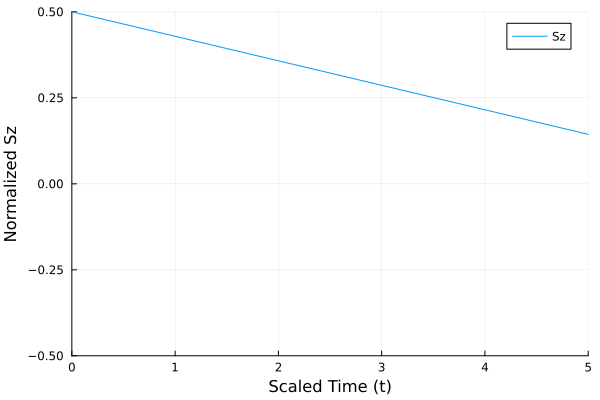

In [37]:
Sz_vals, W = compute_spin_Sz(sol, nAtoms)
# @save "DickeTWA_n=$(nAtoms).jld2" Sz_vals W

plot(nAtoms * Γ * t/log(nAtoms), Sz_vals / nAtoms, 
     label="Sz",
     xlabel="Scaled Time (t)", 
     ylabel="Normalized Sz", 
     xlim=(0.0, 5),
     ylim=(-0.5, 0.5))

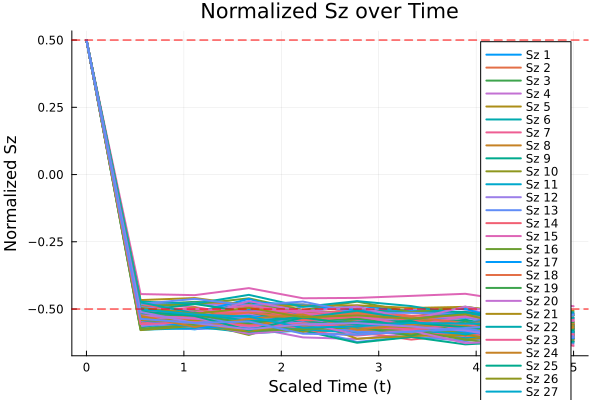

In [38]:
function compute_spin_Sz(sol, nAtoms)
    θ = sol[1:nAtoms, :, :]
    ϕ = sol[nAtoms+1:2*nAtoms, :, :]
    
    Szs = sqrt(3) * cos.(θ) / 2
    return Szs
end
Sz_vals = compute_spin_Sz(sol, nAtoms);
Sz_vals = mean(Sz_vals, dims=3);
# @save "DickeTWA_n=$(nAtoms).jld2" Sz_vals W
plot()

# Loop through each row in Sz_vals and plot
for i in 1:size(Sz_vals, 1)
    plot!(t, Sz_vals[i, :],
        label="Sz $(i)",  # Label for each row
        linewidth=2,
    )  # Set the line width
end
hline!([-0.5, 0.5], line=(:red, :dash))

# Additional plot settings
xlabel!("Scaled Time (t)")
ylabel!("Normalized Sz")
title!("Normalized Sz over Time")

In [39]:
θ = sol[1:nAtoms, :, :]
ϕ = sol[nAtoms+1:2*nAtoms, :, :]
first_term = (sqrt(3) / 2) * sum(mean(cos.(θ[:,:,:]),dims=3), dims=1)[:];

In [40]:
arr = zeros(nAtoms, nAtoms, nT, nTraj)
sin_theta = sin.(θ)
for j = 1:nT
    for i = 1:nTraj
        phi_diff = ϕ[:, j, i]' .- ϕ[:, j, i]  # Compute pairwise differences for phi, shape: (nAtoms, nAtoms)
        cos_phi_diff = cos.(phi_diff)  # Apply cos element-wise, shape: (nAtoms, nAtoms)
        arr[:, :, j, i] .= sin_theta[:, j, i] * sin_theta[:, j, i]' .* cos_phi_diff
    end
end

second_term = (3 / 4) * sum(mean(arr, dims=4), dims=(1,2))[:];

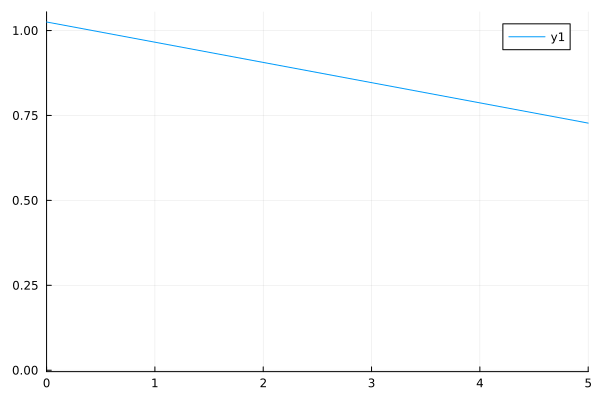

In [41]:
function calculate_and_save_intensity(first_term, second_term, nAtoms, t)
    intensity = abs.(first_term .+ second_term)
    # @save "intensity_through_sum_n=$(nAtoms).jld2" intensity
    plot(t * nAtoms/log(nAtoms), abs.((first_term + second_term)) / nAtoms, xlim=(0, 5))
end

calculate_and_save_intensity(first_term, second_term, nAtoms, t)

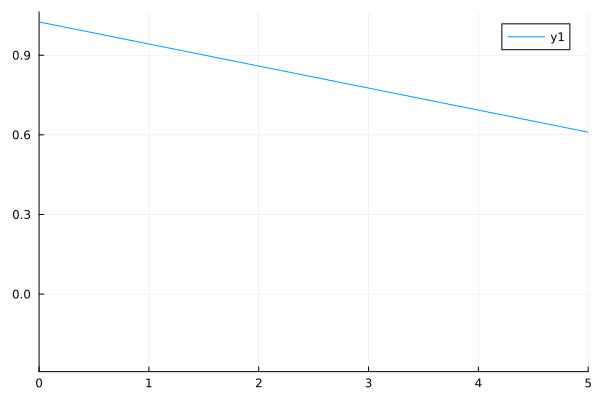

In [42]:
plot(t * nAtoms/log(nAtoms), W / nAtoms, xlim=(0,5))